In [57]:
import pymc3 as pm
import scipy.stats as stats
import matplotlib as mpl
import theano.tensor as tt
from IPython.core.pylabtools import figsize
%matplotlib inline

### Unsupervised Clustering using a Mixture Model

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


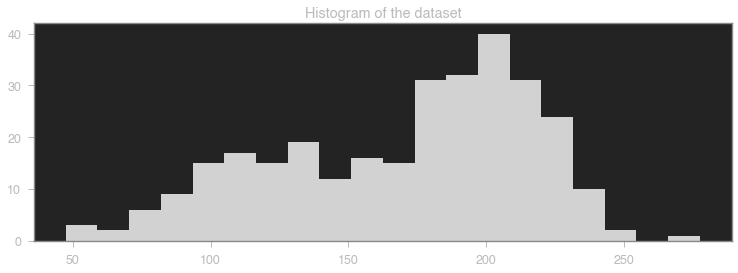

In [2]:
figsize(12.5, 4)

data = np.loadtxt('../data/mixture_data.csv', delimiter=',')

plt.hist(data, bins=20, color="w", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")

What does the data suggest? It appears the data has a bimodal form, that is, it appears to have two peaks, one near 120 and the other near 200. Perhaps there are *two clusters* within this dataset. 

*How* the data might have been created? 

1. For each data point, choose cluster 1 with probability $p$, else choose cluster 2. 
2. Draw a random variate from a Normal distribution with parameters $\mu_i$ and $\sigma_i$ where $i$ was chosen in step 1.
3. Repeat.

This algorithm would create a similar effect as the observed dataset, so we choose this as our model. Of course, we do not know $p$ or the parameters of the Normal distributions. Hence we must infer, or *learn*, these unknowns.

Denote the Normal distributions $\text{N}_0$ and $\text{N}_1$. Both currently have unknown mean and standard deviation, denoted $\mu_i$ and $\sigma_i, \; i =0,1$ respectively. A specific data point can be from either $\text{N}_0$ or $\text{N}_1$, and we assume that the data point is assigned to $\text{N}_0$ with probability $p$.

An appropriate way to assign data points to clusters is to use a PyMC3 `Categorical` stochastic variable. Its parameter is a $k$-length array of probabilities that must sum to one and its `value` attribute is a integer between 0 and $k-1$ randomly chosen according to the crafted array of probabilities (In our case $k=2$). *A priori*, we do not know what the probability of assignment to cluster 1 is, so we form a uniform variable on $(0, 1)$. We call call this $p_1$, so the probability of belonging to cluster 2 is therefore $p_2 = 1 - p_1$.

In [3]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment = pm.Categorical('assignment', p, 
                                shape=data.shape[0], 
                                testval=np.random.randint(0, 2, data.shape[0]))
    
    print(f'prior assignment with p = {p1.tag.test_value:.2f}')
    print(f'{assignment.tag.test_value[:10]}')

prior assignment with p = 0.50
[0 1 1 0 1 0 1 0 1 1]


Looking at the above dataset, I would guess that the standard deviations of the two Normals are different. To maintain ignorance of what the standard deviations might be, we will initially model them as uniform on 0 to 100. We will include both standard deviations in our model using a single line of PyMC3 code:

    sds = pm.Uniform("sds", 0, 100, shape=2)

`shape=2`: we are modeling both $\sigma$s as a single PyMC3 variable.

We also need to specify priors on the centers of the clusters. The centers are really the $\mu$ parameters in these Normal distributions. Their priors can be modeled by a Normal distribution. Looking at the data, I have an idea where the two centers might be &mdash; I would guess somewhere around 120 and 190 respectively. Hence I will set $\mu_0 = 120, \mu_1 = 190$ and $\sigma_0 = \sigma_1 = 10$.

In [4]:
with model:
    sds = pm.Uniform('sds', 0, 100, shape=2)
    centers = pm.Normal('centers', 
                        mu=np.array([120, 190]), sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # combine it with observations
    observations = pm.Normal('obs', mu=center_i, sd=sd_i, observed=data)
    
print(f'Random assignments: {assignment.tag.test_value[:4]}...')
print(f'Assigned center: {center_i.tag.test_value[:4]}...')
print(f'Assigned standard deviation: {sd_i.tag.test_value[:4]}...')

Random assignments: [0 1 1 0]...
Assigned center: [120. 190. 190. 120.]...
Assigned standard deviation: [50. 50. 50. 50.]...


We will tell our model to explore the space that we have so far defined by defining the sampling methods, in this case `Metropolis()` for our continuous variables and `CategoricalGibbsMetropolis()` for our categorical variable. We will use these sampling methods together to explore the space by using `sample( iterations, step )`, where `iterations` is the number of steps you wish the algorithm to perform and `step` is the way in which you want to handle those steps. We use our combination of `Metropolis()` and `CategoricalGibbsMetropolis()` for the `step` and sample 25_000 `iterations` below.

In [16]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace = pm.sample(25_000, step=[step1, step2])

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]
Sampling 2 chains, 0 divergences: 100%|██████████| 51000/51000 [15:54<00:00, 53.45draws/s]
The number of effective samples is smaller than 10% for some parameters.


We have stored the paths of all our variables, or "traces", in the `trace` variable. These paths are the routes the unknown parameters (centers, precisions, and $p$) have taken thus far. 

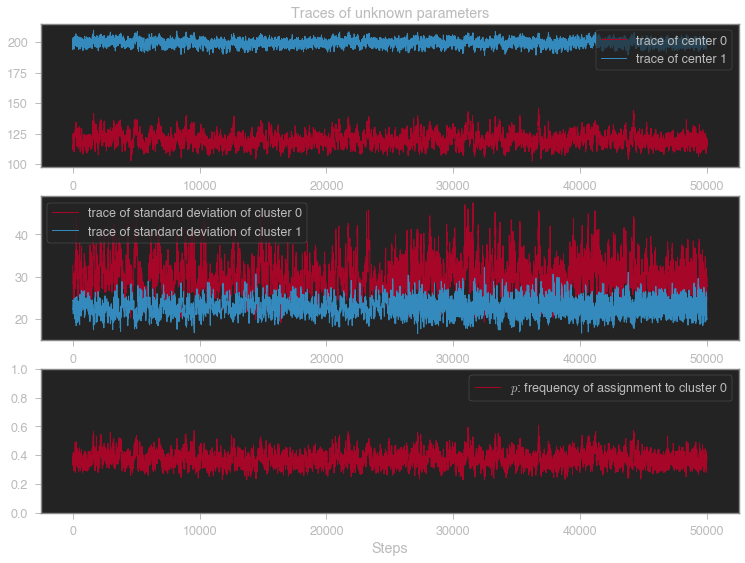

In [17]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

Notice the following characteristics:

1. The traces converges, not to a single point, but to a *distribution* of possible points. This is *convergence* in an MCMC algorithm.
2. Inference using the first few thousand points is a bad idea, as they are unrelated to the final distribution we are interested in. Thus is it a good idea to discard those samples before using the samples for inference. We call this period before converge the *burn-in period*.
3. The traces appear as a random "walk" around the space, that is, the paths exhibit correlation with previous positions. This is both good and bad. We will always have correlation between current positions and the previous positions, but too much of it means we are not exploring the space well.

To achieve further convergence, we will perform more MCMC steps. In the pseudo-code algorithm of MCMC above, the only position that matters is the current position (new positions are investigated near the current position), implicitly stored as part of the `trace` object. To continue where we left off, we pass the `trace` that we have already stored into the `sample()` function with the same step value. The values that we have already calculated will not be overwritten. This ensures that our sampling continues where it left off in the same way that it left off. 

We will sample the MCMC fifty thousand more times and visualize the progress below:

In [18]:
with model:
    trace = pm.sample(50_000, step=[step1, step2], trace=trace)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]
Sampling 2 chains, 0 divergences: 100%|██████████| 101000/101000 [33:42<00:00, 49.93draws/s] 
The number of effective samples is smaller than 10% for some parameters.


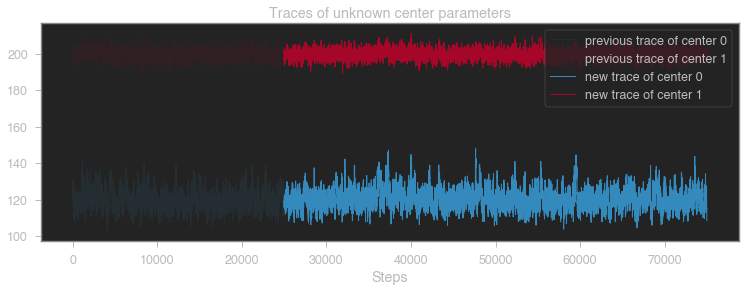

In [52]:
figsize(12.5, 4)
center_trace = trace["centers"][25_000:]
prev_center_trace = trace["centers"][:25_000]

x = np.arange(25_000)
plt.plot(x, prev_center_trace[:, 0], label="previous trace of center 0",
     lw=lw, alpha=0.1, c=colors[1])
plt.plot(x, prev_center_trace[:, 1], label="previous trace of center 1",
     lw=lw, alpha=0.1, c=colors[0])

x = np.arange(25_000, 75_000)
plt.plot(x, center_trace[75_000:, 0], label="new trace of center 0", 
         lw=lw, c="#348ABD")
plt.plot(x, center_trace[75_000:, 1], label="new trace of center 1", 
         lw=lw, c="#A60628")

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");



#### Cluster Investigation

Identify the clusters. We have determined posterior distributions for our unknowns. We plot the posterior distributions of the center and standard deviation variables below:

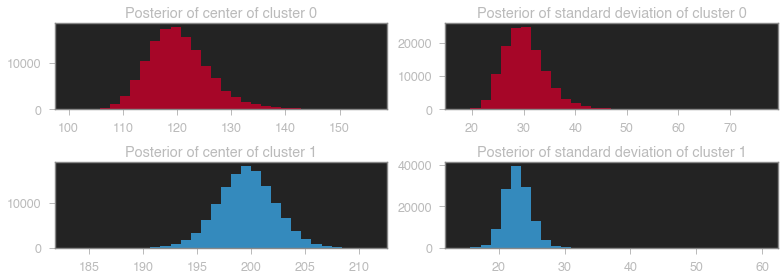

In [56]:
figsize(11.0, 4)
std_trace = trace["sds"][25000:]
prev_std_trace = trace["sds"][:25000]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title(f"Posterior of center of cluster {i}")
    plt.hist(center_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title(f"Posterior of standard deviation of cluster {i}")
    plt.hist(std_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

The MCMC algorithm has proposed that the most likely centers of the two clusters are near 120 and 200 respectively. Similar inference can be applied to the standard deviation. 

We are also given the posterior distributions for the labels of the data point, which is present in `trace["assignment"]`. Below is a visualization of this. The y-axis represents a subsample of the posterior labels for each data point. The x-axis are the sorted values of the data points. A red square is an assignment to cluster 1, and a blue square is an assignment to cluster 0. 

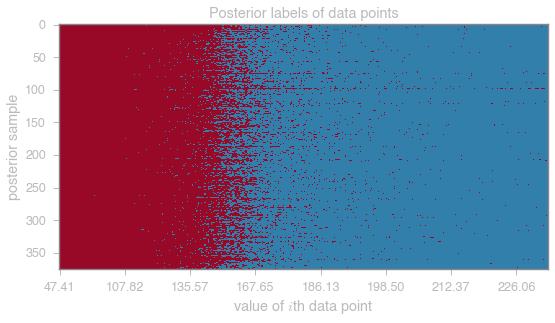

In [61]:
figsize(12.5, 4.5)
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(trace["assignment"][::400, np.argsort(data)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       [f"{s:.2f}" for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

Looking at the above plot, it appears that the most uncertainty is between 150 and 170. The above plot slightly misrepresents things, as the x-axis is not a true scale (it displays the value of the $i$th sorted data point.) A more clear diagram is below, where we have estimated the *frequency* of each data point belonging to the labels 0 and 1. 

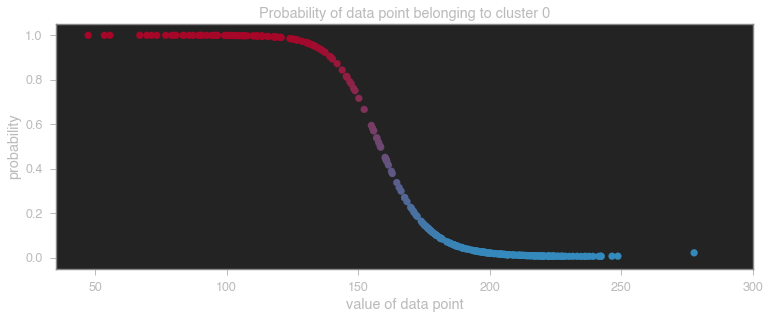

In [62]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

Even though we modeled the clusters using Normal distributions, we didn't get just a single Normal distribution that *best* fits the data, but a distribution of values for the Normal's parameters. How can we choose just a single pair of values for the mean and variance and determine a *sorta-best-fit* gaussian? 

One quick and dirty way, is to use the *mean* of the posterior distributions. Below we overlay the Normal density functions, using the mean of the posterior distributions as the chosen parameters, with our observed data:

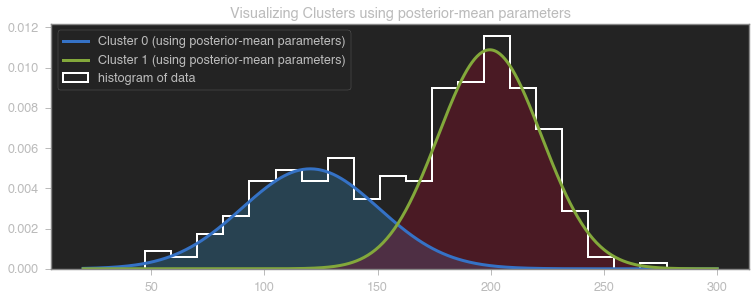

In [64]:
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = center_trace.mean(axis=0)
posterior_std_means = std_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", density=True, color="w",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

### Don't mix posterior samples

In the above example, a possible (though less likely) scenario is that cluster 0 has a very large standard deviation, and cluster 1 has a small standard deviation. This would still satisfy the evidence, albeit less so than our original inference. Alternatively, it would be incredibly unlikely for *both* distributions to have a small standard deviation, as the data does not support this hypothesis at all. Thus the two standard deviations are *dependent* on each other: if one is small, the other must be large. In fact, *all* the unknowns are related in a similar manner. For example, if a standard deviation is large, the mean has a wider possible space of realizations. Conversely, a small standard deviation restricts the mean to a small area. 

During MCMC, we are returned vectors representing samples from the unknown posteriors. Elements of different vectors cannot be used together, as this would break the above logic: perhaps a sample has returned that cluster 1 has a small standard deviation, hence all the other variables in that sample would incorporate that and be adjusted accordingly. It is easy to avoid this problem though, just make sure you are indexing traces correctly. 

Another small example to illustrate the point. Suppose two variables, $x$ and $y$, are related by $x+y=10$. We model $x$ as a Normal random variable with mean 4 and explore 500 samples.  

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [x]
Sampling 2 chains, 0 divergences: 100%|██████████| 21000/21000 [00:24<00:00, 857.41draws/s] 
The number of effective samples is smaller than 25% for some parameters.


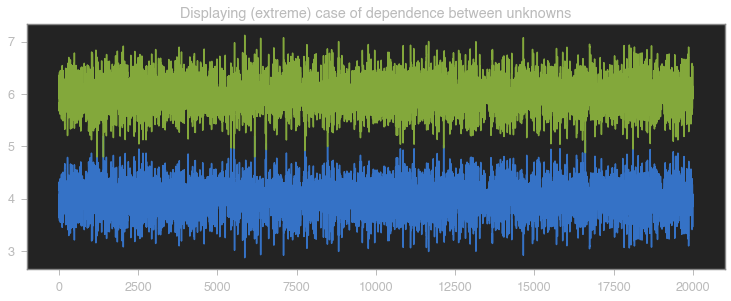

In [65]:
with pm.Model() as model:
    x = pm.Normal("x", mu=4, tau=10)
    y = pm.Deterministic("y", 10 - x)

    trace_2 = pm.sample(10_000, pm.Metropolis())

plt.plot(trace_2["x"])
plt.plot(trace_2["y"])
plt.title("Displaying (extreme) case of dependence between unknowns");

As you can see, the two variables are not unrelated, and it would be wrong to add the $i$th sample of $x$ to the $j$th sample of $y$, unless $i = j$.

#### Prediction
The above clustering can be generalized to $k$ clusters. Choosing $k=2$ allowed us to visualize the MCMC better, and examine some very interesting plots. 

What about prediction? Suppose we observe a new data point, say $x = 175$, and we wish to label it to a cluster. It is foolish to simply assign it to the *closer* cluster center, as this ignores the standard deviation of the clusters, and we have seen from the plots above that this consideration is very important. More formally: we are interested in the *probability* (as we cannot be certain about labels) of assigning $x=175$ to cluster 1. Denote the assignment of $x$ as $L_x$, which is equal to 0 or 1, and we are interested in $P(L_x = 1 \;|\; x = 175 )$.  

A naive method to compute this is to re-run the above MCMC with the additional data point appended. The disadvantage with this method is that it will be slow to infer for each novel data point. Alternatively, we can try a *less precise*, but much quicker method. 

We will use Bayes Theorem for this

$$ P( A | X ) = \frac{ P( X  | A )P(A) }{P(X) }$$

In our case, $A$ represents $L_x = 1$ and $X$ is the evidence we have: we observe that $x = 175$. For a particular sample set of parameters for our posterior distribution, $( \mu_0, \sigma_0, \mu_1, \sigma_1, p)$, we are interested in asking "Is the probability that $x$ is in cluster 1 *greater* than the probability it is in cluster 0?", where the probability is dependent on the chosen parameters.

\begin{align}
& P(L_x = 1| x = 175 ) \gt P(L_x = 0| x = 175 ) \\\\[5pt]
& \frac{ P( x=175  | L_x = 1  )P( L_x = 1 ) }{P(x = 175) } \gt \frac{ P( x=175  | L_x = 0  )P( L_x = 0 )}{P(x = 175) }
\end{align}

As the denominators are equal, they can be ignored (and good riddance, because computing the quantity $P(x = 175)$ can be difficult). 

$$  P( x=175  | L_x = 1  )P( L_x = 1 ) \gt  P( x=175  | L_x = 0  )P( L_x = 0 ) $$


In [73]:
norm_pdf = stats.norm.pdf
p_trace = trace['p'][25_000:]
prev_p_trace = trace['p'][:25_000]
x = 175

v = p_trace * norm_pdf(x, loc=center_trace[:, 0], scale=std_trace[:, 0]) > \
    (1 - p_trace) * norm_pdf(x, loc=center_trace[:, 1], scale=std_trace[:, 1])

print(f"Probability of belonging to cluster 1: {v.mean()}")

Probability of belonging to cluster 1: 0.008992


Giving us a probability instead of a label is a very useful thing. Instead of the naive 

    L = 1 if prob > 0.5 else 0

we can optimize our guesses using a *loss function*.

### Using `MAP` to improve convergence

You may have noticed that our results were not consistent: perhaps your cluster division was more scattered, or perhaps less scattered. The problem is that our traces are a function of the *starting values* of the MCMC algorithm. 

It can be mathematically shown that letting the MCMC run long enough, by performing many steps, the algorithm *should forget its initial position*. In fact, this is what it means to say the MCMC converged (in practice though we can never achieve total convergence). Hence if we observe different posterior analysis, it is likely because our MCMC has not fully converged yet, and we should not use samples from it yet (we should use a larger burn-in period).

In fact, poor starting values can prevent any convergence, or significantly slow it down. Ideally, we would like to have the chain start at the *peak* of our landscape, as this is exactly where the posterior distributions exist. Hence, if we started at the "peak", we could avoid a lengthy burn-in period and incorrect inference. Generally, we call this "peak" the *maximum a posterior* or, more simply, the *MAP*.

Of course, we do not know where the MAP is. PyMC3 provides a function that will approximate, if not find, the MAP location. In the PyMC3 main namespace is the `find_MAP` function. If you call this function within the context of `Model()`, it will calculate the MAP which you can then pass to `pm.sample()` as a `start` parameter.

    start = pm.find_MAP()
    trace = pm.sample(2000, step=pm.Metropolis, start=start)

The `find_MAP()` function has the flexibility of allowing the user to choose which optimization algorithm to use (after all, this is a optimization problem: we are looking for the values that maximize our landscape), as not all optimization algorithms are created equal. The default optimization algorithm in function call is the Broyden-Fletcher-Goldfarb-Shanno ([BFGS](https://en.wikipedia.org/wiki/Broyden-Fletcher-Goldfarb-Shanno_algorithm)) algorithm to find the maximum of the log-posterior. As an alternative, you can use other optimization algorithms from the `scipy.optimize` module. For example, you can use Powell's Method, a favourite of PyMC blogger [Abraham Flaxman](http://healthyalgorithms.com/), by calling `find_MAP(fmin=scipy.optimize.fmin_powell)`. The default works well enough, but if convergence is slow or not guaranteed, feel free to experiment with Powell's method or the other algorithms available. 

The MAP can also be used as a solution to the inference problem, as mathematically it  is the *most likely* value for the unknowns. But as mentioned earlier, this location ignores the uncertainty and doesn't return a distribution.

#### Burn-in period

It is still a good idea to decide on a burn-in period, even if we are using `find_MAP()` prior to sampling, just to be safe. It is easy enough to simply discard the beginning section of the trace just through array slicing. As one does not know when the chain has fully converged, a good rule of thumb is to discard the first *half* of your samples, sometimes up to 90% of the samples for longer runs. To continue the clustering example from above, the new code would look something like:

    with pm.Model() as model:
        start = pm.find_MAP()
        
        step = pm.Metropolis()
        trace = pm.sample(100_000, step=step, start=start)
    
    burned_trace = trace[50_000:]

## Diagnosing Convergence

### Autocorrelation

Autocorrelation is a measure of how related a series of numbers is with itself. A measurement of 1.0 is perfect positive autocorrelation, 0 no autocorrelation, and -1 is perfect negative correlation.  If you are familiar with standard *correlation*, then autocorrelation is just how correlated a series, $x_t$, at time $t$ is with the series at time $t-k$:

$$R(k) = Corr( x_t, x_{t-k} ) $$

For example, consider the two series:

$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$
$$y_t \sim \text{Normal}(y_{t-1}, 1 ), \;\; y_0 = 0$$

which have example paths like:

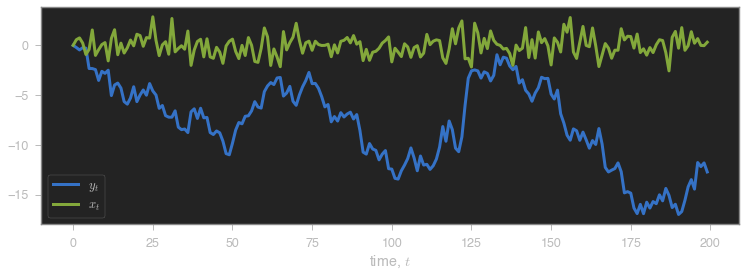

In [83]:
figsize(12.5, 4)

x_t = np.random.normal(0, 1, 200)
x_t[0] = 0
y_t = np.zeros(200)

for i in range(1, 200):
    y_t[i] = np.random.normal(y_t[i - 1], 1)
    
plt.plot(y_t, label='$y_t$', lw=3)
plt.plot(x_t, label='$x_t$', lw=3)
plt.xlabel('time, $t$')
plt.legend();

One way to think of autocorrelation is "If I know the position of the series at time $s$, can it help me know where I am at time $t$?" In the series $x_t$, the answer is No. By construction, $x_t$ are random variables. If I told you that $x_2 = 0.5$, could you give me a better guess about $x_3$? No.

On the other hand, $y_t$ is autocorrelated. By construction, if I knew that $y_2 = 10$, I can be very confident that $y_3$ will not be very far from 10. Similarly, I can even make a (less confident guess) about $y_4$: it will probably not be near 0 or 20, but a value of 5 is not too unlikely. I can make a similar argument about $y_5$, but again, I am less confident. Taking this to it's logical conclusion, we must concede that as $k$, the lag between time points, increases the autocorrelation decreases. We can visualize this:

In [84]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

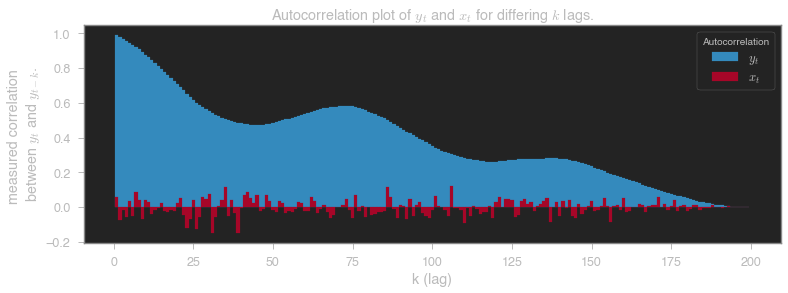

In [85]:
colors = ["#348ABD", "#A60628", "#7A68A6"]

x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$",
        edgecolor=colors[0], color=colors[0])
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color=colors[1], edgecolor=colors[1])

plt.legend(title="Autocorrelation")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.");

Notice that as $k$ increases, the autocorrelation of $y_t$ decreases from a very high point. Compare with the autocorrelation of $x_t$ which looks like noise (which it really is), hence we can conclude no autocorrelation exists in this series. 

#### How does this relate to MCMC convergence?

By the nature of the MCMC algorithm, we will always be returned samples that exhibit autocorrelation (this is because of the step `from your current position, move to a position near you`).

A chain that is not exploring the space well will exhibit very high autocorrelation. Visually, if the trace seems to meander like a river, and not settle down, the chain will have high autocorrelation.

This does not imply that a converged MCMC has low autocorrelation. Hence low autocorrelation is not necessary for convergence, but it is sufficient. PyMC3 has a built-in autocorrelation plotting function in the `plots` module. 

### Thinning

Another issue can arise if there is high-autocorrelation between posterior samples. Many post-processing algorithms require samples to be *independent* of each other. This can be solved, or at least reduced, by only returning to the user every $n$th sample, thus removing some autocorrelation. Below we perform an autocorrelation plot for $y_t$ with differing levels of thinning:

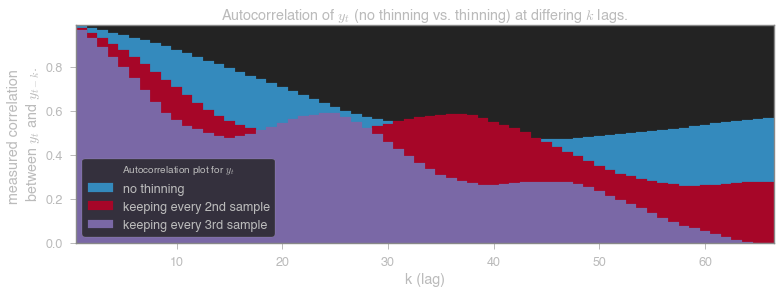

In [86]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x], edgecolor=colors[0],
        label="no thinning", color=colors[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], edgecolor=colors[1],
        label="keeping every 2nd sample", color=colors[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, edgecolor=colors[2],
        label="keeping every 3rd sample", color=colors[2])

plt.autoscale(tight=True)
plt.legend(title="Autocorrelation plot for $y_t$", loc="lower left")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) \
at differing $k$ lags.");

With more thinning, the autocorrelation drops quicker. There is a tradeoff though: higher thinning requires more MCMC iterations to achieve the same number of returned samples. For example, 10_000 samples unthinned is 100_000 with a thinning of 10 (though the latter has less autocorrelation). 

What is a good amount of thinning? The returned samples will always exhibit some autocorrelation, regardless of how much thinning is done. So long as the autocorrelation tends to zero, you are probably ok. Typically thinning of more than 10 is not necessary.

# plots 

The `pymc3.plots` module contains a few different plotting functions that you might find useful. For each different plotting function contained therein, you simply pass a `trace` returned from sampling as well as a list, `varnames`, of the variables that you are interested in. This module can provide you with plots of autocorrelation and the posterior distributions of each variable and their traces, among others.

Below we use the tool to plot the centers of the clusters.

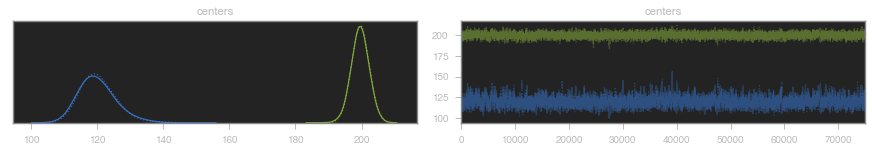

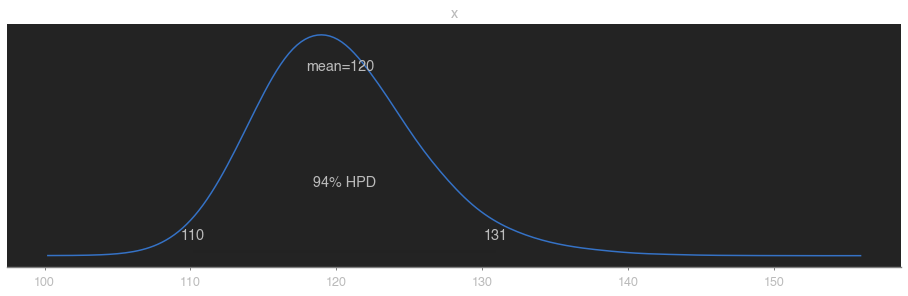

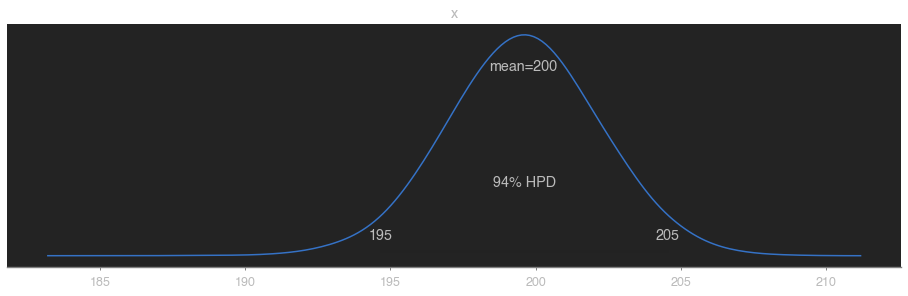

In [91]:
pm.plots.traceplot(trace, var_names=['centers'])
pm.plots.plot_posterior(trace['centers'][:, 0])
pm.plots.plot_posterior(trace['centers'][:, 1]);

The first plotting function gives us the posterior density of each unknown in the `centers` variable as well as the `trace` of each. `trace` plot is useful for inspecting that possible "meandering" property that is a result of non-convergence. The density plot gives us an idea of the shape of the distribution of each unknown, but it is better to look at each of them individually.

The second plotting function(s) provides us with a histogram of the samples with a few added features. The text overlay in the center shows us the posterior mean, which is a good summary of posterior distribution. The interval marked by the horizontal black line overlay represents the *95% credible interval*, sometimes called the *highest posterior density interval* and not to be confused with a *95% confidence interval*. We won't get into the latter, but the former can be interpreted as "there is a 95% chance the parameter of interest lies in this interval". When communicating your results to others, it is incredibly important to state this interval. One of our purposes for studying Bayesian methods is to have a clear understanding of our uncertainty in unknowns. Combined with the posterior mean, the 95% credible interval provides a reliable interval to communicate the likely location of the unknown (provided by the mean) *and* the uncertainty (represented by the width of the interval).

In [96]:
# pm.plots.autocorrplot(trace, var_names=['centers']);